## Task 1 - Teoría

### 1. ¿Qué es el temporal difference learning y en qué se diferencia de los métodos tradicionales de aprendizaje supervisado?
El **Temporal Difference Learning (TD Learning)** es un método de aprendizaje por refuerzo que combina ideas del aprendizaje supervisado y el aprendizaje dinámico. Se diferencia de los métodos tradicionales de aprendizaje supervisado en que no requiere un conjunto de datos etiquetado de antemano, sino que aprende a partir de la experiencia directa con un entorno, ajustando sus estimaciones de valor en cada paso basándose en la diferencia entre las predicciones sucesivas.

#### Error de diferencia temporal:
El **error de diferencia temporal** mide la discrepancia entre la estimación actual del valor de un estado y la estimación corregida basada en la recompensa obtenida y la estimación del siguiente estado:

\[ TD\_error = R_t + \gamma V(S_{t+1}) - V(S_t) \]

Donde:
- \( R_t \) es la recompensa obtenida en el tiempo \( t \)
- \( \gamma \) es el factor de descuento
- \( V(S_t) \) es el valor estimado del estado actual
- \( V(S_{t+1}) \) es el valor estimado del siguiente estado

Este error se usa para actualizar la estimación del valor de los estados, permitiendo el aprendizaje sin necesidad de esperar hasta el final de un episodio.

---

### 2. Juegos Simultáneos y Toma de Decisiones
En los **juegos simultáneos**, los jugadores toman decisiones sin conocer previamente las acciones de sus oponentes. Esto implica que deben formular estrategias basadas en la suposición de lo que harán los demás jugadores.

#### Ejemplo del mundo real:
Un ejemplo de un **juego simultáneo** es el mercado de precios entre dos empresas competidoras. Si dos compañías venden productos similares, deben decidir simultáneamente el precio sin conocer la decisión de su competidor. Las estrategias pueden incluir:
- **Estrategia conservadora:** Mantener precios estables.
- **Estrategia agresiva:** Reducir precios para captar más mercado.
- **Estrategia mixta:** Ajustar precios de manera probabilística basada en el comportamiento pasado del oponente.

---

### 3. Juegos de Suma Cero vs. No Suma Cero
Los **juegos de suma cero** son aquellos donde la ganancia de un jugador es exactamente igual a la pérdida del otro. En cambio, en los **juegos de no suma cero**, los jugadores pueden obtener beneficios mutuos o compartir pérdidas.

#### Ejemplo de juego de no suma cero:
Un caso clásico es la **negociación salarial** entre un empleador y un trabajador. Si ambas partes cooperan, pueden encontrar un acuerdo en el que ambos se beneficien (por ejemplo, un salario justo con beneficios). Las estrategias incluyen:
- **Cooperación:** Buscar un acuerdo justo para ambas partes.
- **Competencia:** Intentar maximizar la propia ganancia a expensas del otro.
- **Compromiso:** Ceder en ciertos aspectos para obtener mejores términos en otros.

---

### 4. Equilibrio de Nash en Juegos Simultáneos
El **equilibrio de Nash** es un concepto en el cual, dado que todos los jugadores han elegido sus estrategias, ningún jugador tiene incentivos para cambiar unilateralmente su decisión, ya que esto no mejoraría su resultado.

#### Ejemplo:
En el **dilema del prisionero**, si ambos jugadores eligen la estrategia de "confesar", están en un equilibrio de Nash porque ninguno mejora su situación cambiando su decisión unilateralmente.

En juegos simultáneos, el equilibrio de Nash ayuda a identificar estrategias óptimas en situaciones de incertidumbre, permitiendo a los jugadores anticipar las acciones de sus oponentes.

---

### 5. Aplicación del Temporal Difference Learning en Procesos de Toma de Decisiones
El **TD Learning** se usa en múltiples aplicaciones donde los sistemas deben aprender en entornos dinámicos, como en el control de robots, juegos de mesa (ejemplo: AlphaGo), y en optimización de procesos industriales.

#### Exploración vs. Explotación
El algoritmo maneja este equilibrio mediante:
- **Exploración (Exploration):** Intentar nuevas acciones para descubrir mejores estrategias.
- **Explotación (Exploitation):** Usar la mejor estrategia conocida hasta el momento.

Una técnica común para manejar este balance es el **ε-greedy**, donde se elige la mejor acción con probabilidad \( 1 - \epsilon \) y una acción aleatoria con probabilidad \( \epsilon \).

#### Desafíos en la implementación:
- **Convergencia lenta**: En entornos complejos, la convergencia puede requerir muchas iteraciones.
- **Riesgo de sobreajuste**: Si se optimiza demasiado para un entorno específico, puede no generalizar bien a otros contextos.
- **Exploración insuficiente**: Si \( \epsilon \) es demasiado bajo, el modelo puede quedar atrapado en una estrategia subóptima.

---


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random

# Parámetros de aprendizaje
GAMMA = 0.95  # Factor de descuento
ALPHA = 0.01  # Tasa de aprendizaje
EPSILON = 1.0  # Factor de exploración
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.1
BATCH_SIZE = 32
MEMORY_SIZE = 10000

# Configuración del tablero
ROWS = 6
COLS = 7

# Funciones de utilidad para el juego
def get_valid_moves(board):
    """Devuelve las columnas donde se pueden hacer jugadas válidas."""
    return [col for col in range(COLS) if board[0][col] == 0]

def check_winner(board, player):
    """Verifica si un jugador ha ganado."""
    # Comprobación horizontal, vertical y diagonal
    for row in range(ROWS):
        for col in range(COLS - 3):
            if all(board[row][col + i] == player for i in range(4)):
                return True

    for row in range(ROWS - 3):
        for col in range(COLS):
            if all(board[row + i][col] == player for i in range(4)):
                return True

    for row in range(ROWS - 3):
        for col in range(COLS - 3):
            if all(board[row + i][col + i] == player for i in range(4)):
                return True

    for row in range(3, ROWS):
        for col in range(COLS - 3):
            if all(board[row - i][col + i] == player for i in range(4)):
                return True

    return False

def is_full(board):
    """Verifica si el tablero está lleno."""
    return all(board[0][col] != 0 for col in range(COLS))

class ConnectFourAgent:
    def __init__(self):
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """Construye el modelo de la red neuronal para aproximar Q-valor."""
        model = keras.Sequential([
            keras.layers.Flatten(input_shape=(ROWS, COLS)),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(COLS, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=ALPHA), loss='mse')
        return model

    def update_target_model(self):
        """Actualiza los pesos del modelo objetivo con los pesos del modelo actual."""
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """Selecciona la acción (columna) basada en el estado actual."""
        if np.random.rand() < self.epsilon:
            return random.choice(get_valid_moves(state))
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)
        valid_moves = get_valid_moves(state)
        return max(valid_moves, key=lambda x: q_values[0][x])

    def remember(self, state, action, reward, next_state, done):
        """Guarda la experiencia (transición) en la memoria del agente."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Actualiza el modelo basado en las transiciones de la memoria."""
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += GAMMA * np.max(self.target_model.predict(next_state[np.newaxis, :], verbose=0))
            q_values = self.model.predict(state[np.newaxis, :], verbose=0)
            q_values[0][action] = target
            states.append(state)
            targets.append(q_values[0])
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

    def reduce_epsilon(self):
        """Disminuye el valor de epsilon para reducir la exploración."""
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY

    def play_game(self, train=True):
        """Hace que el agente juegue una partida contra sí mismo o un oponente fijo."""
        board = np.zeros((ROWS, COLS), dtype=int)
        done = False
        turn = 1  # 1 para el agente, -1 para el oponente
        while not done:
            state = board.copy()
            action = self.act(state)
            row = next(r for r in range(ROWS - 1, -1, -1) if board[r][action] == 0)
            board[row][action] = turn
            reward = 0
            if check_winner(board, turn):
                reward = 1 if turn == 1 else -1
                done = True
            elif is_full(board):
                reward = 0
                done = True
            if train:
                self.remember(state, action, reward, board.copy(), done)
                self.replay()
            turn *= -1  # Cambiar turno
        return reward

# Inicializar el agente
agent = ConnectFourAgent()


c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
#Implementar un agente minimax. ya tiene implementado el arbol... 
def minimax(board, depth, maximizing_player, alpha, beta):
    """Función Minimax con poda Alpha-Beta."""
    valid_moves = get_valid_moves(board)
    if depth == 0 or check_winner(board, 1) or check_winner(board, -1) or is_full(board):
        return evaluate_board(board, maximizing_player)
    
    if maximizing_player:
        max_eval = -float('inf')
        for move in valid_moves:
            row = next(r for r in range(ROWS - 1, -1, -1) if board[r][move] == 0)
            board[row][move] = 1  # Agente Max
            eval = minimax(board, depth - 1, False, alpha, beta)
            board[row][move] = 0  # Deshacer el movimiento
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = float('inf')
        for move in valid_moves:
            row = next(r for r in range(ROWS - 1, -1, -1) if board[r][move] == 0)
            board[row][move] = -1  # Agente Min
            eval = minimax(board, depth - 1, True, alpha, beta)
            board[row][move] = 0  # Deshacer el movimiento
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def evaluate_board(board, player):
    """Evaluación de tablero: devuelve una puntuación positiva si el jugador actual tiene ventaja."""
    if check_winner(board, player):
        return 100000  # Ganar tiene una puntuación alta
    elif check_winner(board, -player):
        return -100000  # Perder tiene una puntuación baja
    else:
        return 0  # No hay ganador todavía


In [15]:
#Funcion para jugar entre los 3 agentes. 
def play_game(agent_td, agent_minimax, agent_minimax_ab, num_games=50):
    results = {'TD': 0, 'Minimax': 0, 'MinimaxAB': 0}
    
    for _ in range(num_games):
        # TD vs Minimax
        winner = play_game_between_agents(agent_td, agent_minimax)
        if winner == 1:
            results['TD'] += 1
        elif winner == -1:
            results['Minimax'] += 1
        
        # TD vs MinimaxAB
        winner = play_game_between_agents(agent_td, agent_minimax_ab)
        if winner == 1:
            results['TD'] += 1
        elif winner == -1:
            results['MinimaxAB'] += 1
        
        # Minimax vs MinimaxAB
        winner = play_game_between_agents(agent_minimax, agent_minimax_ab)
        if winner == 1:
            results['Minimax'] += 1
        elif winner == -1:
            results['MinimaxAB'] += 1
    
    return results

def play_game_between_agents(agent1, agent2):
    """Simula un juego entre dos agentes."""
    board = np.zeros((ROWS, COLS), dtype=int)
    done = False
    turn = 1  # 1 para el agente 1, -1 para el agente 2
    while not done:
        if turn == 1:
            action = agent1.act(board) if isinstance(agent1, ConnectFourAgent) else minimax(board, 5, True, -float('inf'), float('inf'))
        else:
            action = agent2.act(board) if isinstance(agent2, ConnectFourAgent) else minimax(board, 5, True, -float('inf'), float('inf'))
        
        row = next(r for r in range(ROWS - 1, -1, -1) if board[r][action] == 0)
        board[row][action] = turn
        if check_winner(board, turn):
            done = True
            return turn  # 1 si gana el primer agente, -1 si gana el segundo
        elif is_full(board):
            done = True
            return 0  # Empate
        
        turn *= -1  # Cambiar turno

c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


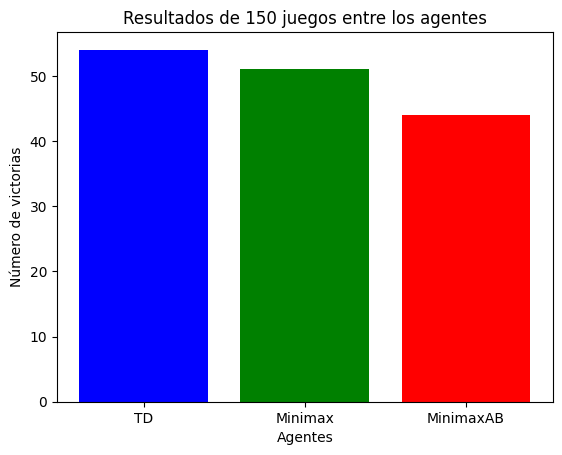

In [16]:
#Simulacion de los juegos y grafico de resultados
import matplotlib.pyplot as plt

# Simula los juegos y guarda los resultados
results = play_game(agent, ConnectFourAgent(), ConnectFourAgent(), num_games=50)

# Graficar resultados
agents = ['TD', 'Minimax', 'MinimaxAB']
victories = [results['TD'], results['Minimax'], results['MinimaxAB']]

plt.bar(agents, victories, color=['blue', 'green', 'red'])
plt.xlabel('Agentes')
plt.ylabel('Número de victorias')
plt.title('Resultados de 150 juegos entre los agentes')
plt.savefig("resultados_juegos.jpg")

In [17]:
from fpdf import FPDF

# Crear el documento PDF
pdf = FPDF()
pdf.add_page()

# Título
pdf.set_font("Arial", size=16)
pdf.cell(200, 10, txt="Resultados de los Juegos entre Agentes", ln=True, align='C')

# Agregar gráfico
pdf.ln(10)
pdf.image("resultados_juegos.jpg", x=10, y=30, w=180)

# Guardar el documento PDF
pdf.output("resultados_juegos_final.pdf")


''